L'objectif de ce code est de lire le document de tracking et d'en extraire uniquement les trajectoires que l'on veut étudier pour faire le fichier finales des trajectoires que l'on va étudier. Cela évitera tout problème par la suite dans le traitement globale des données. Chaque manip ayant ses propres paramètres de traitement (luminosité, taille etc...) On aura tout ce qu'il nous faut directement dans le fichier final sans avoir à retravailler les fichiers et avoir des difficulités dues aux paramètres différents. 
Pour cela : 
                1- On charge le fichier de la manip qu'on veut étudier. 
                2- On traite créé les trajectoires.
                3- On trie. 
                4- On enregistre le nouveau fichier. 

In [99]:
import pandas as pd
import os
import re
import trackpy as tp

In [100]:
def remove_drift(traj, smooth, save=False, pathway_saving=None, name=None, img_type="jpg"):
    """
    Remove overall drift motion.

    Remove overall drift motion from trajectories by adopting
    the referenceframe of the particles' average position.

    Parameters
    ----------
    traj : pd.DataFrame
        DataFrame containing the trajectories.
    smooth : int
        Smoothing value used to smooth the drift curves.

    Returns
    -------
    corrected_traj : pd.DataFrame
        DataFrame containing the corrected trajectories.
    """
    # Calculate drift
    drift = tp.compute_drift(traj, smooth)

    # Plot drift curves
    plt.figure(figsize=(20, 20))
    drift.plot(color=['blue', 'red'], linestyle='dotted')

    # Add title and axis labels
    plt.title(f'Drift Curves of {name}', fontsize=40,
              fontweight="bold", fontstyle='italic', fontname="Arial")
    plt.xlabel('Frame number', fontsize=16, fontstyle='italic')
    plt.ylabel('Drift (pixel)', fontsize=14, color='red')

    # Add grid
    plt.grid()

    # Set axis limits
    plt.xlim([0, traj['frame'].max()])
    plt.ylim([-10, 10])

    plt.tight_layout()
    # plt.clf()
    # plt.close()
    if save:
        if pathway_saving is not None:
            plt.savefig(pathway_saving+f'drift{name}.' + img_type,
                        format=img_type, dpi=None, bbox_inches='tight')
        else:
            save = False
    # Correct trajectories by subtracting the drift
    corrected_traj = tp.subtract_drift(traj, drift)
    plt.show()
    plt.close()

    return corrected_traj

In [101]:
def read_hdf5_single_file(filepath: str, condition: str, manip_name: str, name_file: str = 'features',
                          nbr_frame_min: int =200, drift=False, search_range: int = 100,
                          memory: int = 5, adaptive_stop: int = 30, min_mass_raw: int = 1000, max_size: int = 40):
    """
    Read a single traj hdf5 file.

    Parameters
    ----------
    filepath : string
        absolute path to the traj hdf5 file.
    condition : str
        specific condition of the experiment.

    Returns
    -------
    data : pd.DataFrame
        DataFrame of the trajectories info, with new columns (particle positions, and experiment name)

    """
    # Initialize an empty DataFrame
    data = pd.DataFrame()
    
    # Checking if the file exists and matches the criteria
    filepath = os.path.join(filepath, name_file + '.hdf5')
    if filepath.endswith(".hdf5") and name_file in filepath:
        try:
            data = pd.read_hdf(filepath, key='table')
            print(data)
        except ValueError as e:
            print(f"Error reading {filepath}: {e}")
            return pd.DataFrame()  # Return empty DataFrame in case of error

        # Apply linking if 'features' file
        if name_file == 'features' and 'particle' not in data.columns:
            data = tp.link_df(data, search_range=search_range, memory=memory,
                              neighbor_strategy='KDTree', link_strategy='auto',
                              adaptive_stop=adaptive_stop)
        
        # Filter data based on mass and size if columns exist
        if 'size' in data.columns and 'mass' in data.columns and 'raw_mass' in data.columns:
            mean_mass_by_particle = data.groupby('particle')['raw_mass'].mean()
            particles_to_keep = mean_mass_by_particle[mean_mass_by_particle > min_mass_raw].index
            data = data[data['particle'].isin(particles_to_keep)]

        # Filter particles based on the minimum number of frames
        counts = data.groupby(['particle']).size()
        particles_to_keep = counts[counts >= nbr_frame_min].reset_index(name='count')
        data = data.merge(particles_to_keep, on=['particle'])
        data['experiment'] = manip_name
        data['condition'] = condition
        
        # Assuming remove_drift is a function defined elsewhere if needed
        if drift:
            data = remove_drift(traj=data, smooth=2, save=True, pathway_saving=os.path.dirname(filepath),
                                name=manip_name)
            data = data.drop('frame', axis=1).reset_index(drop=True)
            


    print(manip_name, " : ", data['particle'].nunique())
    # print("Nombre de particules récoltées avant tri: ", data_all['particle'].nunique())
    return data

In [102]:
PATHWAY_EXPERIMENTS= '/Users/souchaud/Desktop/Analyses/'
PATHWAY_PICTURES= '/Users/souchaud/Desktop/A_analyser/'
CONDITION='CytoOne_HL5_10x'
MANIP='ASMOT144'
PATHWAY=os.path.join(PATHWAY_EXPERIMENTS, CONDITION + '_new_param/')
# Parcourir les dossiers dans PATHWAY
for dir_name in os.listdir(PATHWAY):
    if MANIP in dir_name:
        MANIP_NAME = dir_name
        break
PATHWAY_RESULTS = os.path.join(PATHWAY, MANIP_NAME)
PATHWAY_RESULTS = os.path.join(PATHWAY_RESULTS, 'mosaic/')
print(PATHWAY_RESULTS)

PATHWAY_PICTURES= os.path.join(PATHWAY_PICTURES, CONDITION + '_faits')
# Parcourir les dossiers dans PATHWAY
for dir_name in os.listdir(PATHWAY_PICTURES):
    if MANIP in dir_name:
        PATHWAY_PICTURES = os.path.join(PATHWAY_PICTURES, dir_name, 'mosaic/')
        break
print(PATHWAY_PICTURES)

/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_new_param/2024_03_26_ASMOT144_AX3_2024_P1_10x_CytoOne_HL5_2603-17h00-2703-14h25/mosaic/
/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x_faits/2024_03_26_ASMOT144_AX3_2024_P1_10x_CytoOne_HL5_2603-17h00-2703-14h25/mosaic/


In [103]:
FILE_NAME='features'
N_FRAME_MIN_STUDY=175
DRIFT=False
SEARCH_RANGE=30
MEMORY=5
MIN_MASS_RAW=500
MAX_SIZE=40
ADAPTIVE_STOP= 15

In [104]:
DATA = read_hdf5_single_file(filepath=PATHWAY_RESULTS, manip_name=MANIP, 
                             name_file=FILE_NAME, nbr_frame_min=N_FRAME_MIN_STUDY, condition=CONDITION, drift=DRIFT,
                             search_range=SEARCH_RANGE, memory=MEMORY, min_mass_raw=MIN_MASS_RAW, 
                             adaptive_stop=ADAPTIVE_STOP, max_size=MAX_SIZE)

Frame 339: 127 trajectories present.
ASMOT144  :  106


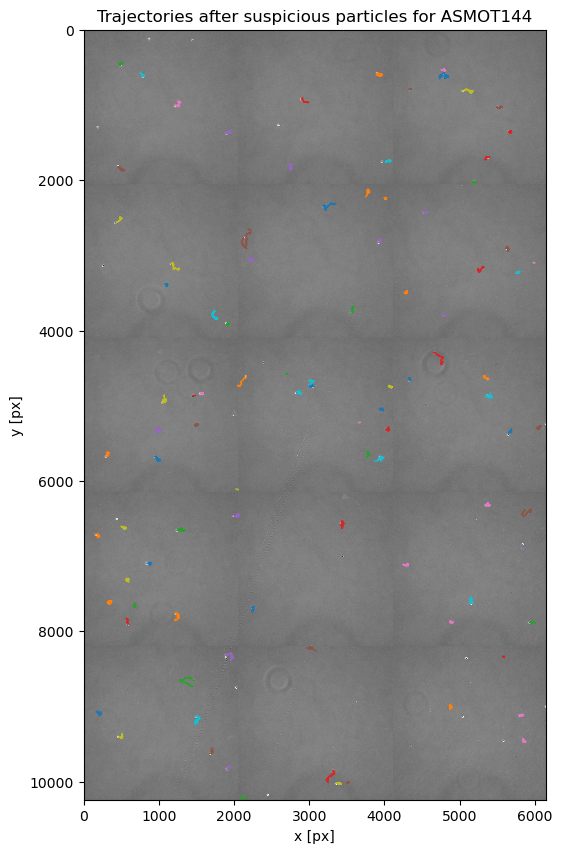

In [105]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# Construction du chemin complet vers l'image à utiliser comme fond
image_path_directory = f'{PATHWAY_PICTURES}/mosaic_total_0.tif'  # Ajustez selon le nom de fichier et le chemin d'accès réel

# Lecture de l'image
frame = imageio.imread(image_path_directory)

# Créer la figure et les axes pour le sous-graphique
fig, ax = plt.subplots(figsize=(10, 10))  # Ajustez la taille selon vos besoins

# Tracer les trajectoires sur l'image
ax.set_aspect('equal', 'box')
ax.set_title(f'Trajectories after suspicious particles for {MANIP}')
tp.plot_traj(DATA, superimpose=frame, label=False, ax=ax)

# Afficher le graphique
plt.show()

In [106]:
DATA.to_hdf(os.path.join(PATHWAY_RESULTS, 'filtered_final.hdf5'), 'table')

In [107]:
DATA

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,count,experiment,condition
0,7091.999638,838.103553,2149.852203,4.038458,0.051574,29.714290,11506.0,-0.101372,0,1,260,ASMOT144,CytoOne_HL5_10x
1,7091.483744,850.088653,2373.118097,4.080723,0.055800,32.018508,12955.0,-0.140177,1,1,260,ASMOT144,CytoOne_HL5_10x
2,7091.359634,854.448425,2156.844365,4.003789,0.061446,31.444105,11904.0,-0.109872,2,1,260,ASMOT144,CytoOne_HL5_10x
3,7091.374481,858.243663,2051.009522,3.953534,0.087234,30.565052,10896.0,-0.090363,3,1,260,ASMOT144,CytoOne_HL5_10x
4,7090.563579,860.116168,2415.903394,4.083606,0.091136,32.902676,12921.0,-0.139146,4,1,260,ASMOT144,CytoOne_HL5_10x
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30407,1867.976294,543.223643,1649.546508,3.972051,0.303154,26.411953,14540.0,-0.249282,335,505,190,ASMOT144,CytoOne_HL5_10x
30408,1868.647618,543.105878,1505.435564,3.909236,0.269162,25.167356,14106.0,-0.206513,336,505,190,ASMOT144,CytoOne_HL5_10x
30409,1867.743144,542.420987,1479.984125,3.993190,0.235051,23.127145,14222.0,-0.217501,337,505,190,ASMOT144,CytoOne_HL5_10x
30410,1869.586628,543.345268,1298.651385,3.916064,0.231517,21.561074,12738.0,-0.135008,338,505,190,ASMOT144,CytoOne_HL5_10x
